### 베이지안 최적화(Bayesian Optimization)
##### 참고: https://www.youtube.com/watch?app=desktop&v=w9D8ozS0oC4
<img src="./images/bayesian_optimization.png" width="700" style="margin-left: -20px">  

- 최소의 시도로 최적의 답을 찾기 위해서 사용하며, 개별 시도에 있어서 많은 시간 및 자원이 필요할 때도 사용한다.
- 미지의 함수가 리턴하는 값의 최소 또는 최대값을 만드는 최적의 해를 짧은 반복을 통해 찾아내는 최적화 방식이다.
- 새로운 데이터를 입력받았을 때 최적 함수를 예측하는 모델을 개선해 나가면서 최적 함수를 도출한다.
- 대체 모델과 획득 함수로 구성되며, 대체 모델은 획득 함수로부터 최적 입력 값을 추천받은 뒤 이를 기반으로 개선해나간다.  
획득 함수는 개선된 대체 모델을 기반으로 다시 최적 입력 값을 계산한다.
- 함수의 공분산(covariance)이 크다는 것은 곧 불확실성이 크다는 의미이므로 공분산이 최대인 지점을 다음 샘플링 포인트로 선정한다.
- 📌공분산(Cov)이란, 2개의 확률변수의 선형 관계를 나타내는 값으로서, 서로 다른 변수들 사이에 얼마나 의존하는지를 수치적으로 표현한다.

---
<div style="display: flex">
    <div>
        <p style="width: 90%; text-align:center">공분산이 양수일 경우</p>
        <img src="./images/covariance01.png" width="700" style="margin-left: -30px">
    </div>
    <div>
        <p style="width: 90%; text-align:center">공분산이 음수일 경우</p>
        <img src="./images/covariance02.png" width="700" style="margin-left: -30px">
    </div>
    <div>
        <p style="width: 90%; text-align:center">공분산이 0일 경우</p>
        <img src="./images/covariance03.png" width="700" style="margin-left: -30px">
    </div>
</div>  
  
##### 🚩공분산이 큰, x = 2인 지점에 샘플링을 하면, 불확실성이 감소하게 된다.
<div style="display: flex">
    <div>
        <img src="./images/bayesian01.png" width="500" style="margin-left: -40px; margin-bottom: 20px">
    </div>
    <div>
        <img src="./images/bayesian02.png" width="465" style="margin-left: -30px">
    </div>
</div>  
  
##### 🚩공분산이 큰, x = -0.5인 지점에 샘플링을 하면, 불확실성이 감소하게 된다.
<div style="display: flex">
    <div>
        <img src="./images/bayesian02.png" width="460" style="margin-left: -20px; margin-bottom: 20px">
    </div>
    <div>
        <img src="./images/bayesian03.png" width="455" style="margin-left: -10px">
    </div>
</div>  


In [1]:
import xgboost

print(xgboost.__version__)

1.7.3


In [2]:
import pandas as pd

corona_df = pd.read_csv('./datasets/corona.csv', low_memory=False)
corona_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278848 entries, 0 to 278847
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Ind_ID               278848 non-null  int64 
 1   Test_date            278848 non-null  object
 2   Cough_symptoms       278596 non-null  object
 3   Fever                278596 non-null  object
 4   Sore_throat          278847 non-null  object
 5   Shortness_of_breath  278847 non-null  object
 6   Headache             278847 non-null  object
 7   Corona               278848 non-null  object
 8   Age_60_above         151528 non-null  object
 9   Sex                  259285 non-null  object
 10  Known_contact        278848 non-null  object
dtypes: int64(1), object(10)
memory usage: 23.4+ MB


In [3]:
corona_df = corona_df[~corona_df['Cough_symptoms'].isna()]
corona_df = corona_df[~corona_df['Fever'].isna()]
corona_df = corona_df[~corona_df['Sore_throat'].isna()]
corona_df = corona_df[~corona_df['Headache'].isna()]
corona_df.isna().sum()

Ind_ID                      0
Test_date                   0
Cough_symptoms              0
Fever                       0
Sore_throat                 0
Shortness_of_breath         0
Headache                    0
Corona                      0
Age_60_above           127315
Sex                     19552
Known_contact               0
dtype: int64

In [4]:
corona_df['Target'] = corona_df['Corona']
corona_df.drop(columns='Corona', axis=1, inplace=True)
corona_df

Ind_ID   Test_date Cough_symptoms  Fever Sore_throat  \
0            1  11-03-2020           True  False        True   
1            2  11-03-2020          False   True       False   
2            3  11-03-2020          False   True       False   
3            4  11-03-2020           True  False       False   
4            5  11-03-2020           True  False       False   
...        ...         ...            ...    ...         ...   
278843  278844  30-04-2020          False  False       False   
278844  278845  30-04-2020          False  False       False   
278845  278846  30-04-2020          False  False       False   
278846  278847  30-04-2020          False  False       False   
278847  278848  30-04-2020          False  False       False   

       Shortness_of_breath Headache Age_60_above     Sex  \
0                    False    False          NaN     NaN   
1                    False    False          NaN     NaN   
2                    False    False          NaN     NaN   
3                    False    False          NaN     NaN   
4                    False    False          NaN     NaN   
...                    ...      ...          ...     ...   
278843               False    False          NaN    male   
278844               False    False          NaN  female   
278845               False    False          NaN    male   
278846               False    False          NaN    male   
278847               False    False          NaN  female   

                 Known_contact    Target  
0                       Abroad  negative  
1                       Abroad  positive  
2                       Abroad  positive  
3                       Abroad  negative  
4       Contact with confirmed  negative  
...                        ...       ...  
278843                   Other  positive  
278844                   Other  negative  
278845                   Other  negative  
278846                   Other  negative  
278847                   Other  negative  

[278594 rows x 11 columns]

In [5]:
corona_df = corona_df[corona_df['Target'] != 'other']
corona_df['Target'].value_counts()

Target
negative    260008
positive     14694
Name: count, dtype: int64

In [6]:
corona_df = corona_df.drop(columns=['Ind_ID', 'Test_date', 'Sex', 'Known_contact', 'Age_60_above'], axis=1)
corona_df

Cough_symptoms  Fever Sore_throat Shortness_of_breath Headache  \
0                True  False        True               False    False   
1               False   True       False               False    False   
2               False   True       False               False    False   
3                True  False       False               False    False   
4                True  False       False               False    False   
...               ...    ...         ...                 ...      ...   
278843          False  False       False               False    False   
278844          False  False       False               False    False   
278845          False  False       False               False    False   
278846          False  False       False               False    False   
278847          False  False       False               False    False   

          Target  
0       negative  
1       positive  
2       positive  
3       negative  
4       negative  
...          ...  
278843  positive  
278844  negative  
278845  negative  
278846  negative  
278847  negative  

[274702 rows x 6 columns]

In [7]:
from sklearn.preprocessing import LabelEncoder

columns = ['Fever', 'Sore_throat', 'Shortness_of_breath', 'Headache', 'Cough_symptoms', 'Target']

for column in columns:
    encoder = LabelEncoder()
    targets = encoder.fit_transform(corona_df[column])
    corona_df.loc[:, column] = targets
    print(f'{column}_classes: {encoder.classes_}')

Fever_classes: [False True]
Sore_throat_classes: [False True]
Shortness_of_breath_classes: [False True]
Headache_classes: [False True]
Cough_symptoms_classes: [False True]
Target_classes: ['negative' 'positive']


In [8]:
# 각 카테고리 값을 정수 타입으로 변환 !
corona_df = corona_df.astype('int16')
corona_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274702 entries, 0 to 278847
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   Cough_symptoms       274702 non-null  int16
 1   Fever                274702 non-null  int16
 2   Sore_throat          274702 non-null  int16
 3   Shortness_of_breath  274702 non-null  int16
 4   Headache             274702 non-null  int16
 5   Target               274702 non-null  int16
dtypes: int16(6)
memory usage: 5.2 MB


In [9]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

features, targets = corona_df.iloc[:, :-1], corona_df.Target

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify=targets, test_size=0.3)

# 오버 샘플링
# 검증 데이터나 테스트 데이터가 아닌 학습데이터에서만 오버샘플링 사용할 것
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print('SMOTE 적용 전:\n',pd.Series(y_train).value_counts() )
print('SMOTE 적용 후:\n',pd.Series(y_train_over).value_counts() )

# 학습 데이터를 검증 데이터로 분리
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.5)

evals = [(X_val_train, y_val_train), (X_val_test, y_val_test)]

SMOTE 적용 전:
 Target
0    182005
1     10286
Name: count, dtype: int64
SMOTE 적용 후:
 Target
1    182005
0    182005
Name: count, dtype: int64


In [10]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
import matplotlib.pyplot as plt
# 타겟 데이터와 예측 객체를 전달받는다.
def get_evaluation(y_test, prediction, classifier=None, X_test=None):
#     오차 행렬
    confusion = confusion_matrix(y_test, prediction)
#     정확도
    accuracy = accuracy_score(y_test, prediction)
#     정밀도
    precision = precision_score(y_test, prediction)
#     재현율
    recall = recall_score(y_test, prediction)
#     F1 score
    f1 = f1_score(y_test, prediction)
#     ROC-AUC
    roc_auc = roc_auc_score(y_test, prediction)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy , precision ,recall, f1, roc_auc))
    print("#" * 75)
    
    if classifier is not None and  X_test is not None:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]

        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, ax=ax, cmap=plt.cm.Blues)
            disp.ax_.set_title(title)
        plt.show()

In [11]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
# 목적 함수 정의
def objective(trial):
    # 하이퍼파라미터 탐색 공간 정의
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    
    model = LGBMClassifier(
        boost_from_average=False,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=124
    )
    
    # 모델 학습
    model.fit(X_train_over, y_train_over, early_stopping_rounds=50, eval_set=evals)
    
    # 테스트 데이터에 대한 예측
    prediction = model.predict(X_test)
    
    # 검증 데이터에 대한 평가
    get_evaluation(y_test, prediction)
    auc = roc_auc_score(y_test, prediction)
    return auc

In [12]:
# conda install -c conda-forge optuna
import optuna
import time

start_time = time.time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("optuna 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

C:\ProgramData\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-10-17 13:37:03,002] A new study created in memory with name: no-name-eac816bc-8bc0-4df8-aade-816c8770084b
C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:03,868] Trial 0 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 1000, 'max_depth': 12}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[15]	valid_0's binary_logloss: 0.521138	valid_1's binary_logloss: 0.520934
[16]	valid_0's binary_logloss: 0.518128	valid_1's binary_logloss: 0.517904
[17]	valid_0's binary_logloss: 0.515502	valid_1's binary_logloss: 0.515258
[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss

[I 2023-10-17 13:37:04,777] Trial 1 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 13}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[14]	valid_0's binary_logloss: 0.524589	valid_1's binary_logloss: 0.524406
[15]	valid_0's binary_logloss: 0.521138	valid_1's binary_logloss: 0.520934
[16]	valid_0's binary_logloss: 0.518128	valid_1's binary_logloss: 0.517904
[17]	valid_0's binary_logloss: 0.515502	valid_1's binary_logloss: 0.515258
[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss

[I 2023-10-17 13:37:05,608] Trial 2 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 8}. Best is trial 0 with value: 0.7449736724840472.
C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:06,487] Trial 3 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 700, 'max_depth': 6}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.524589	valid_1's binary_logloss: 0.524406
[15]	valid_0's binary_logloss: 0.521138	valid_1's binary_logloss: 0.520934
[16]	valid_0's binary_logloss: 0.518128	valid_1's binary_logloss: 0.517904
[17]	valid_0's binary_logloss: 0.515502	valid_1's binary_logloss: 0.515258
[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss:

[I 2023-10-17 13:37:07,343] Trial 4 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 800, 'max_depth': 12}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.524589	valid_1's binary_logloss: 0.524406
[15]	valid_0's binary_logloss: 0.521138	valid_1's binary_logloss: 0.520934
[16]	valid_0's binary_logloss: 0.518128	valid_1's binary_logloss: 0.517904
[17]	valid_0's binary_logloss: 0.515502	valid_1's binary_logloss: 0.515258
[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss:

[I 2023-10-17 13:37:08,232] Trial 5 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[17]	valid_0's binary_logloss: 0.515502	valid_1's binary_logloss: 0.515258
[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss

[I 2023-10-17 13:37:09,022] Trial 6 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 500, 'max_depth': 6}. Best is trial 0 with value: 0.7449736724840472.


[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:09,787] Trial 7 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 200, 'max_depth': 8}. Best is trial 0 with value: 0.7449736724840472.
C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:10,613] Trial 8 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 400, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss: 0.500171	valid_1's binary_logloss: 0.499653
[32]	valid_0's binary_loglos

[I 2023-10-17 13:37:11,401] Trial 9 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 800, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:12,324] Trial 10 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 1000, 'max_depth': 15}. Best is trial 0 with value: 0.7449736724840472.


[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:13,335] Trial 11 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 1000, 'max_depth': 13}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.524589	valid_1's binary_logloss: 0.524406
[15]	valid_0's binary_logloss: 0.521138	valid_1's binary_logloss: 0.520934
[16]	valid_0's binary_logloss: 0.518128	valid_1's binary_logloss: 0.517904
[17]	valid_0's binary_logloss: 0.515502	valid_1's binary_logloss: 0.515258
[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss

[I 2023-10-17 13:37:14,110] Trial 12 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 300, 'max_depth': 12}. Best is trial 0 with value: 0.7449736724840472.


[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
####################################################################

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:14,857] Trial 13 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 600, 'max_depth': 15}. Best is trial 0 with value: 0.7449736724840472.
C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:15,607] Trial 14 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 400, 'max_depth': 10}. Best is trial 0 with value: 0.7449736724840472.


[91]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[92]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binar

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:16,342] Trial 15 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 900, 'max_depth': 11}. Best is trial 0 with value: 0.7449736724840472.


[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's bi

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:17,088] Trial 16 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 500, 'max_depth': 14}. Best is trial 0 with value: 0.7449736724840472.


[90]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[91]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[92]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:17,824] Trial 17 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 700, 'max_depth': 10}. Best is trial 0 with value: 0.7449736724840472.


[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:18,569] Trial 18 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 300, 'max_depth': 13}. Best is trial 0 with value: 0.7449736724840472.


[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's bin

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:19,291] Trial 19 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 600, 'max_depth': 9}. Best is trial 0 with value: 0.7449736724840472.


[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's bin

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:20,118] Trial 20 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 200, 'max_depth': 12}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.524589	valid_1's binary_logloss: 0.524406
[15]	valid_0's binary_logloss: 0.521138	valid_1's binary_logloss: 0.520934
[16]	valid_0's binary_logloss: 0.518128	valid_1's binary_logloss: 0.517904
[17]	valid_0's binary_logloss: 0.515502	valid_1's binary_logloss: 0.515258
[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss

[I 2023-10-17 13:37:20,875] Trial 21 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 8}. Best is trial 0 with value: 0.7449736724840472.


[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:21,608] Trial 22 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 8}. Best is trial 0 with value: 0.7449736724840472.


[89]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497135
[90]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[91]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[92]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
#

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:22,365] Trial 23 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 200, 'max_depth': 11}. Best is trial 0 with value: 0.7449736724840472.


[91]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[92]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binar

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:23,122] Trial 24 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 300, 'max_depth': 14}. Best is trial 0 with value: 0.7449736724840472.


[92]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's bina

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:23,947] Trial 25 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 400, 'max_depth': 9}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.524589	valid_1's binary_logloss: 0.524406
[15]	valid_0's binary_logloss: 0.521138	valid_1's binary_logloss: 0.520934
[16]	valid_0's binary_logloss: 0.518128	valid_1's binary_logloss: 0.517904
[17]	valid_0's binary_logloss: 0

[I 2023-10-17 13:37:24,954] Trial 26 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 200, 'max_depth': 11}. Best is trial 0 with value: 0.7449736724840472.


[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:25,983] Trial 27 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 900, 'max_depth': 13}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.524589	valid_1's binary_logloss: 0.524406
[15]	valid_0's binary_logloss: 0.521138	valid_1's binary_logloss: 0.520934
[16]	valid_0's binary_logloss: 0.518128	valid_1's binary_logloss: 0.517904
[17]	valid_0's binary_logloss: 0.515502	valid_1's binary_logloss: 0.515258
[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss

[I 2023-10-17 13:37:26,733] Trial 28 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 14}. Best is trial 0 with value: 0.7449736724840472.


[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:27,462] Trial 29 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 700, 'max_depth': 7}. Best is trial 0 with value: 0.7449736724840472.


[90]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[91]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[92]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:28,195] Trial 30 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 300, 'max_depth': 10}. Best is trial 0 with value: 0.7449736724840472.
C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:28,933] Trial 31 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 800, 'max_depth': 7}. Best is trial 0 with value: 0.7449736724840472.
C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:29,768] Trial 32 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 900, 'max_depth': 6}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[16]	valid_0's binary_logloss: 0.518128	valid_1's binary_logloss: 0.517904
[17]	valid_0's binary_logloss: 0.515502	valid_1's binary_logloss: 0.515258
[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss

[I 2023-10-17 13:37:30,594] Trial 33 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 700, 'max_depth': 6}. Best is trial 0 with value: 0.7449736724840472.


[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:31,476] Trial 34 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 500, 'max_depth': 7}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss: 0.500171	valid_1's binary_logloss: 0.499653
[32]	valid_0's binary_logloss: 0.499837	valid_1's binary_logloss: 0.499303
[33]	valid_0's binary_logloss: 0.499549	valid_1's binary_logloss: 0.498998
[34]	valid_0's binary_loglo

[I 2023-10-17 13:37:32,261] Trial 35 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 1000, 'max_depth': 9}. Best is trial 0 with value: 0.7449736724840472.


[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:33,030] Trial 36 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 12}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[14]	valid_0's binary_logloss: 0.524589	valid_1's binary_logloss: 0.524406
[15]	valid_0's binary_logloss: 0.521138	valid_1's binary_logloss: 0.520934
[16]	valid_0's binary_logloss: 0.518128	valid_1's binary_logloss: 0.517904
[17]	valid_0's binary_logloss: 0.515502	valid_1's binary_logloss: 0.515258
[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss

[I 2023-10-17 13:37:33,808] Trial 37 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 800, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:34,596] Trial 38 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 900, 'max_depth': 8}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.524589	valid_1's binary_logloss: 0.524406
[15]	valid_0's binary_logloss: 0.521138	valid_1's binary_logloss: 0.520934
[16]	valid_0's binary_logloss: 0.518128	valid_1's binary_logloss: 0.517904
[17]	valid_0's binary_logloss: 0.515502	valid_1's binary_logloss: 0.515258
[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss:

[I 2023-10-17 13:37:35,416] Trial 39 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 600, 'max_depth': 13}. Best is trial 0 with value: 0.7449736724840472.


[92]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's bina

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:36,189] Trial 40 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 200, 'max_depth': 6}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss

[I 2023-10-17 13:37:36,975] Trial 41 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 800, 'max_depth': 12}. Best is trial 0 with value: 0.7449736724840472.


[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:37,778] Trial 42 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 1000, 'max_depth': 11}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss

[I 2023-10-17 13:37:38,533] Trial 43 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 700, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:39,304] Trial 44 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 800, 'max_depth': 13}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss: 0.500171	valid_1's binary_logloss: 0.499653
[32]	valid_0's binary_logloss: 0.499837	valid_1's binary_logloss: 0.499303
[33]	valid_0's binary_loglo

[I 2023-10-17 13:37:40,045] Trial 45 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 700, 'max_depth': 12}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[17]	valid_0's binary_logloss: 0.515502	valid_1's binary_logloss: 0.515258
[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss

[I 2023-10-17 13:37:40,837] Trial 46 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 900, 'max_depth': 15}. Best is trial 0 with value: 0.7449736724840472.


[92]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's bina

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:41,599] Trial 47 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 500, 'max_depth': 14}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss

[I 2023-10-17 13:37:42,506] Trial 48 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 600, 'max_depth': 10}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss

[I 2023-10-17 13:37:43,415] Trial 49 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 400, 'max_depth': 11}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss: 0.500171	valid_1's binary_logloss: 0.499653
[32]	valid_0's binary_logloss: 0.499837	valid_1's binary_logloss: 0.499303
[33]	valid_0's binary_logloss: 0.499549	valid_1's binary_logloss: 0.498998
[34]	valid_0's binary_loglo

[I 2023-10-17 13:37:44,207] Trial 50 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 1000, 'max_depth': 13}. Best is trial 0 with value: 0.7449736724840472.


[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:44,930] Trial 51 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


[87]	valid_0's binary_logloss: 0.497956	valid_1's binary_logloss: 0.497135
[88]	valid_0's binary_logloss: 0.497956	valid_1's binary_logloss: 0.497135
[89]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497135
[90]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[91]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[92]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_lo

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:45,663] Trial 52 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


[90]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[91]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[92]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:46,495] Trial 53 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 200, 'max_depth': 6}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.524589	valid_1's binary_logloss: 0.524406
[15]	valid_0's binary_logloss: 0.521138	valid_1's binary_logloss: 0.520934
[16]	valid_0's binary_logloss: 0.518128	valid_1's binary_logloss: 0.517904
[17]	valid_0's binary_logloss: 0.515502	valid_1's binary_logloss: 0.515258
[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss:

[I 2023-10-17 13:37:47,291] Trial 54 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 200, 'max_depth': 7}. Best is trial 0 with value: 0.7449736724840472.


[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:48,055] Trial 55 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 6}. Best is trial 0 with value: 0.7449736724840472.


[88]	valid_0's binary_logloss: 0.497956	valid_1's binary_logloss: 0.497135
[89]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497135
[90]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[91]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[92]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:48,835] Trial 56 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 300, 'max_depth': 8}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss: 0.500171	valid_1's binary_logloss: 0.499653
[32]	valid_0's binary_logloss: 0.499837	valid_1's binary_logloss: 0.499303
[33]	valid_0's binary_loglo

[I 2023-10-17 13:37:49,576] Trial 57 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 400, 'max_depth': 10}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss: 0.500171	valid_1's binary_logloss: 0.499653
[32]	valid_0's binary_logloss: 0.499837	valid_1's binary_logloss: 0.499303
[33]	valid_0's binary_loglo

[I 2023-10-17 13:37:50,351] Trial 58 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 12}. Best is trial 0 with value: 0.7449736724840472.


[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:51,123] Trial 59 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 200, 'max_depth': 9}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[16]	valid_0's binary_logloss: 0.518128	valid_1's binary_logloss: 0.517904
[17]	valid_0's binary_logloss: 0.515502	valid_1's binary_logloss: 0.515258
[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss

[I 2023-10-17 13:37:51,905] Trial 60 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 600, 'max_depth': 7}. Best is trial 0 with value: 0.7449736724840472.


[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:52,619] Trial 61 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 800, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's bin

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:53,307] Trial 62 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 500, 'max_depth': 6}. Best is trial 0 with value: 0.7449736724840472.


[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:54,026] Trial 63 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 900, 'max_depth': 7}. Best is trial 0 with value: 0.7449736724840472.


[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
####################################################################

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:54,750] Trial 64 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 300, 'max_depth': 6}. Best is trial 0 with value: 0.7449736724840472.


[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's b

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:55,473] Trial 65 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 700, 'max_depth': 14}. Best is trial 0 with value: 0.7449736724840472.


[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:56,264] Trial 66 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 200, 'max_depth': 15}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss

[I 2023-10-17 13:37:56,977] Trial 67 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 1000, 'max_depth': 11}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss: 0.500171	valid_1's binary_logloss: 0.499653
[32]	valid_0's binary_logloss: 0.499837	valid_1's binary_logloss: 0.499303
[33]	valid_0's binary_logloss: 0.499549	valid_1's binary_logloss: 0.498998
[34]	valid_0's binary_logloss: 0.4993	valid_1's binary_logloss: 0.498733
[35]	valid_0's binary_logloss: 0.499085	valid_1's binary_logloss: 0.498502
[36]	valid_0's binary_logloss: 0.4989	valid_1's binary_logloss: 0.498303
[37]	valid_0's binary_logloss: 0.498741	valid_1's binary_logloss: 0.49813
[38]	valid_0's binary_logloss: 0.498605	valid_1's binary_logloss: 0.49798
[39]	valid_0's binary_logloss: 0.49849	valid_1's binary_logloss: 0.497852
[40]	valid_0's binary_logloss: 0

[I 2023-10-17 13:37:57,662] Trial 68 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 600, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss: 0.500171	valid_1's binary_logloss: 0.499653
[32]	valid_0's binary_logloss: 0.499837	valid_1's binary_logloss: 0.499303
[33]	valid_0's binary_logloss: 0.499549	valid_1's binary_logloss: 0.498998
[34]	valid_0's binary_logloss: 0.4993	valid_1's binary_logloss: 0.498733
[35]	valid_0's binary_logloss: 0.499085	valid_1's binary_logloss: 0.498502
[36]	valid_0's binary_logloss: 0.4989	valid_1's binary_logloss: 0.498303
[37]	valid_0's binary_logloss:

[I 2023-10-17 13:37:58,320] Trial 69 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 8}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss: 0.500171	valid_1's binary_logloss: 0.499653
[32]	valid_0's binary_logloss: 0.499837	valid_1's binary_logloss: 0.499303
[33]	valid_0's binary_logloss: 0.499549	valid_1's binary_logloss: 0.498998
[34]	valid_0's binary_logloss: 0.4993	valid_1's binary_logloss: 0.498733
[35]	valid_0's binary_logloss: 0.499085	valid_1's binary_logloss: 0.498502
[36]	valid_0's binary_logloss: 0.4989	valid_1's binary_logloss: 0.498303
[37]	valid_0's binary_logloss:

[I 2023-10-17 13:37:59,059] Trial 70 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 900, 'max_depth': 12}. Best is trial 0 with value: 0.7449736724840472.


[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:37:59,790] Trial 71 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 8}. Best is trial 0 with value: 0.7449736724840472.


[86]	valid_0's binary_logloss: 0.497956	valid_1's binary_logloss: 0.497135
[87]	valid_0's binary_logloss: 0.497956	valid_1's binary_logloss: 0.497135
[88]	valid_0's binary_logloss: 0.497956	valid_1's binary_logloss: 0.497135
[89]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497135
[90]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[91]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[92]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_log

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:00,484] Trial 72 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 6}. Best is trial 0 with value: 0.7449736724840472.


[91]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[92]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:01,196] Trial 73 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 200, 'max_depth': 13}. Best is trial 0 with value: 0.7449736724840472.


[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
####################################################################

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:01,867] Trial 74 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 9}. Best is trial 0 with value: 0.7449736724840472.


[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:02,582] Trial 75 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 500, 'max_depth': 7}. Best is trial 0 with value: 0.7449736724840472.


[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
####################################################################

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:03,299] Trial 76 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 800, 'max_depth': 13}. Best is trial 0 with value: 0.7449736724840472.


[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
####################################################################

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:04,020] Trial 77 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 300, 'max_depth': 6}. Best is trial 0 with value: 0.7449736724840472.


[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's bi

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:04,797] Trial 78 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 200, 'max_depth': 11}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss: 0.500171	valid_1's binary_logloss: 0.499653
[32]	valid_0's binary_logloss: 0.499837	valid_1's binary_logloss: 0.499303
[33]	valid_0's binary_logloss: 0.499549	valid_1's binary_logloss: 0.498998
[34]	valid_0's binary_logloss: 0.4993	valid_1's binary_logloss: 0.498733
[35]	valid_0's binary_logloss: 0.499085	valid_1's binary_logloss: 0.498502
[36]	valid_0's binary_loglos

[I 2023-10-17 13:38:05,582] Trial 79 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 9}. Best is trial 0 with value: 0.7449736724840472.


[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:06,271] Trial 80 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 700, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's bi

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:06,972] Trial 81 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 500, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


[92]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's bina

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:07,606] Trial 82 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 400, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[18]	valid_0's binary_logloss: 0.51321	valid_1's binary_logloss: 0.512946
[19]	valid_0's binary_logloss: 0.51121	valid_1's binary_logloss: 0.510924
[20]	valid_0's binary_logloss: 0.509463	valid_1's binary_logloss: 0.509156
[21]	valid_0's binary_logloss: 0.507937	valid_1's binary_logloss: 0.50761
[22]	valid_0's binary_logloss: 0.506605	valid_1's binary_logloss: 0.506257
[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss

[I 2023-10-17 13:38:08,273] Trial 83 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 400, 'max_depth': 12}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss: 0.500171	valid_1's binary_logloss: 0.499653
[32]	valid_0's binary_logloss: 0.499837	valid_1's binary_logloss: 0.499303
[33]	valid_0's binary_logloss: 0.499549	valid_1's binary_logloss: 0.498998
[34]	valid_0's binary_logloss: 0.4993	valid_1's binary_logloss: 0.498733
[35]	valid_0's binary_logloss: 0.499085	valid_1's binary_logloss: 0.498502
[36]	valid_0's binary_logloss: 0.4989	valid_1's binary_logloss: 0.498303
[37]	valid_0's binary_logloss: 0.498741	valid_1's binary_logloss: 0.49813
[38]	valid_0's binary_logloss: 0.498605	valid_1's binary_logloss: 0.49798
[39]	valid_0's binary_logloss: 0.49849	valid_1's binary_logloss: 0.497852
[40]	valid_0's binary_logloss: 0.498391	valid_1's binary_logloss: 0.49774
[41]	valid_0's binary_logloss: 0.

[I 2023-10-17 13:38:08,924] Trial 84 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 600, 'max_depth': 6}. Best is trial 0 with value: 0.7449736724840472.
C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

[I 2023-10-17 13:38:09,600] Trial 85 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 200, 'max_depth': 10}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss: 0.500171	valid_1's binary_logloss: 0.499653
[32]	valid_0's binary_logloss: 0.499837	valid_1's binary_logloss: 0.499303
[33]	valid_0's binary_logloss: 0.499549	valid_1's binary_logloss: 0.498998
[34]	valid_0's binary_logloss: 0.4993	valid_1's binary_logloss: 0.498733
[35]	valid_0's binary_logloss: 0.499085	valid_1's binary_logloss: 0.498502
[36]	valid_0's binary_logloss: 0.4989	valid_1's binary_logloss: 0.498303
[37]	valid_0's binary_logloss: 0.498741	valid_1's binary_logloss: 0.49813
[38]	valid_0's binary_logloss: 

[I 2023-10-17 13:38:10,242] Trial 86 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 500, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss: 0.500171	valid_1's binary_logloss: 0.499653
[32]	valid_0's binary_logloss: 0.499837	valid_1's binary_logloss: 0.499303
[33]	valid_0's binary_logloss: 0.499549	valid_1's binary_logloss: 0.498998
[34]	valid_0's binary_logloss: 0.4993	valid_1's binary_logloss: 0.498733
[35]	valid_0's binary_logloss: 0.499085	valid_1's binary_logloss: 0.498502
[36]	valid_0's binary_logloss: 0.4989	valid_1's binary_logloss: 0.498303
[37]	valid_0's binary_logloss: 0.498741	valid_1's binary_logloss: 0.49813
[38]	valid_0's binary_logloss: 0.498605	valid_1's binary_logloss: 0.49798
[39]	valid_0's binary_logloss: 

[I 2023-10-17 13:38:10,864] Trial 87 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 7}. Best is trial 0 with value: 0.7449736724840472.
C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:11,524] Trial 88 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 700, 'max_depth': 6}. Best is trial 0 with value: 0.7449736724840472.


[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:12,185] Trial 89 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 400, 'max_depth': 13}. Best is trial 0 with value: 0.7449736724840472.


[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:12,881] Trial 90 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 800, 'max_depth': 12}. Best is trial 0 with value: 0.7449736724840472.


[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
####################################################################

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:13,603] Trial 91 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 900, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


[90]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[91]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[92]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:14,339] Trial 92 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 300, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


[87]	valid_0's binary_logloss: 0.497956	valid_1's binary_logloss: 0.497135
[88]	valid_0's binary_logloss: 0.497956	valid_1's binary_logloss: 0.497135
[89]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497135
[90]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[91]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[92]	valid_0's binary_logloss: 0.497957	valid_1's binary_logloss: 0.497136
[93]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[94]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_lo

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:15,096] Trial 93 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 800, 'max_depth': 6}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss: 0.500171	valid_1's binary_logloss: 0.499653
[32]	valid_0's binary_logloss: 0.499837	valid_1's binary_logloss: 0.499303
[33]	valid_0's binary_logloss: 0.499549	valid_1's binary_logloss: 0.498998
[34]	valid_0's binary_logloss: 0.4993	valid_1's binary_logloss: 0.498733
[35]	valid_0's binary_logloss: 0.499085	valid_1's binary_logloss: 0.498502
[36]	valid_0's binary_logloss: 0.4989	valid_1's binary_logloss: 0.498303
[37]	valid_0's binary_logloss: 0.498741	valid_1's binary_logloss: 0.49813
[38]	valid_0's binary_logloss: 0.498605	valid_1's binary_logloss: 0.49798
[39]	valid_0's binary_logloss: 0.49849	valid_1's binary_logloss: 0.497852
[40]	valid_0's binary_logloss: 0

[I 2023-10-17 13:38:15,765] Trial 94 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 600, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[23]	valid_0's binary_logloss: 0.505441	valid_1's binary_logloss: 0.505074
[24]	valid_0's binary_logloss: 0.504426	valid_1's binary_logloss: 0.504039
[25]	valid_0's binary_logloss: 0.50354	valid_1's binary_logloss: 0.503133
[26]	valid_0's binary_logloss: 0.502768	valid_1's binary_logloss: 0.502341
[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss: 0.500171	valid_1's binary_logloss: 0.499653
[32]	valid_0's binary_logloss: 0.499837	valid_1's binary_logloss: 0.499303
[33]	valid_0's binary_logloss: 0.499549	valid_1's binary_logloss: 0.498998
[34]	valid_0's binary_logloss: 0.4993	valid_1's binary_logloss: 0.498733
[35]	valid_0's binary_logloss: 0.499085	valid_1's binary_logloss: 0.498502
[36]	valid_0's binary_loglos

[I 2023-10-17 13:38:16,527] Trial 95 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 900, 'max_depth': 6}. Best is trial 0 with value: 0.7449736724840472.


[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:17,230] Trial 96 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 1000, 'max_depth': 5}. Best is trial 0 with value: 0.7449736724840472.


[95]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[96]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[97]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[98]	valid_0's binary_logloss: 0.497958	valid_1's binary_logloss: 0.497136
[99]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[100]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[101]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[102]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[103]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[104]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[105]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[106]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's b

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:17,904] Trial 97 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 700, 'max_depth': 10}. Best is trial 0 with value: 0.7449736724840472.


[107]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
[108]	valid_0's binary_logloss: 0.497959	valid_1's binary_logloss: 0.497136
오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

[I 2023-10-17 13:38:18,548] Trial 98 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 100, 'max_depth': 7}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid

C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[27]	valid_0's binary_logloss: 0.502095	valid_1's binary_logloss: 0.501649
[28]	valid_0's binary_logloss: 0.501508	valid_1's binary_logloss: 0.501044
[29]	valid_0's binary_logloss: 0.500998	valid_1's binary_logloss: 0.500516
[30]	valid_0's binary_logloss: 0.500555	valid_1's binary_logloss: 0.500055
[31]	valid_0's binary_logloss: 0.500171	valid_1's binary_logloss: 0.499653
[32]	valid_0's binary_logloss: 0.499837	valid_1's binary_logloss: 0.499303
[33]	valid_0's binary_logloss: 0.499549	valid_1's binary_logloss: 0.498998
[34]	valid_0's binary_logloss: 0.4993	valid_1's binary_logloss: 0.498733
[35]	valid_0's binary_logloss: 0.499085	valid_1's binary_logloss: 0.498502
[36]	valid_0's binary_logloss: 0.4989	valid_1's binary_logloss: 0.498303
[37]	valid_0's binary_logloss: 0.498741	valid_1's binary_logloss: 0.49813
[38]	valid_0's binary_logloss: 0.498605	valid_1's binary_logloss: 0.49798
[39]	valid_0's binary_logloss: 0.49849	valid_1's binary_logloss: 0.497852
[40]	valid_0's binary_logloss: 0

[I 2023-10-17 13:38:19,203] Trial 99 finished with value: 0.7449736724840472 and parameters: {'n_estimators': 800, 'max_depth': 14}. Best is trial 0 with value: 0.7449736724840472.


오차 행렬
[[66159 11844]
 [ 1579  2829]]
정확도: 0.8371, 정밀도: 0.1928, 재현율: 0.6418, F1:0.2965, AUC:0.7450
###########################################################################
optuna 수행 시간: 76.2 초 


In [13]:
best_params = study.best_params
best_score = study.best_value

print('Best Parameters:', best_params)
print('Best Score:', best_score)

Best Parameters: {'n_estimators': 1000, 'max_depth': 12}
Best Score: 0.7449736724840472


C:\ProgramData\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's binary_logloss: 0.665734	valid_1's binary_logloss: 0.665733
[2]	valid_0's binary_logloss: 0.642557	valid_1's binary_logloss: 0.642552
[3]	valid_0's binary_logloss: 0.622852	valid_1's binary_logloss: 0.622841
[4]	valid_0's binary_logloss: 0.606023	valid_1's binary_logloss: 0.606003
[5]	valid_0's binary_logloss: 0.591598	valid_1's binary_logloss: 0.591567
[6]	valid_0's binary_logloss: 0.579196	valid_1's binary_logloss: 0.579152
[7]	valid_0's binary_logloss: 0.568504	valid_1's binary_logloss: 0.568446
[8]	valid_0's binary_logloss: 0.559268	valid_1's binary_logloss: 0.559195
[9]	valid_0's binary_logloss: 0.551273	valid_1's binary_logloss: 0.551184
[10]	valid_0's binary_logloss: 0.544343	valid_1's binary_logloss: 0.544237
[11]	valid_0's binary_logloss: 0.538327	valid_1's binary_logloss: 0.538203
[12]	valid_0's binary_logloss: 0.533099	valid_1's binary_logloss: 0.532955
[13]	valid_0's binary_logloss: 0.52855	valid_1's binary_logloss: 0.528387
[14]	valid_0's binary_logloss: 0.52

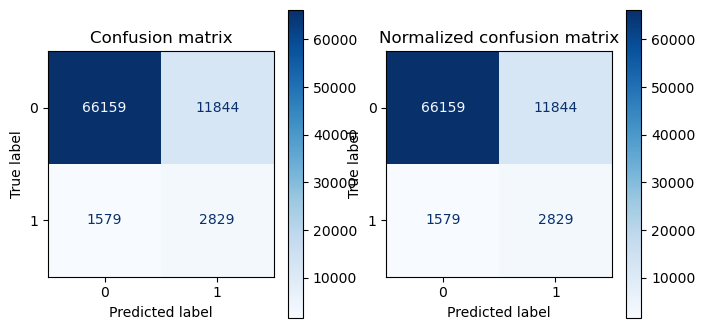

In [14]:
model = LGBMClassifier(
        boost_from_average=False,
        n_estimators=1000,
        max_depth=12,
        random_state=124
    )

model.fit(X_train_over, y_train_over, early_stopping_rounds=50, eval_set=evals)

prediction = model.predict(X_test)

get_evaluation(y_test, prediction, model, X_test)